In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          DataCollatorWithPadding,
                          Trainer, TrainingArguments)
from torch.utils.data import Dataset, DataLoader
# from datasets import Dataset
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Фиксируем random seed

In [2]:
# фиксируем рандомный сид
seed  = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

In [3]:
# детектируем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Задание констант

In [4]:

classes_list = ["Algebra", "Geometry and Trigonometry", "Calculus and Analysis",
                "Probability and Statistics", "Number Theory", "Combinatorics and Discrete Math",
                "Linear Algebra", "Abstract Algebra and Topology"]
n_classes = len(classes_list)

train_csv_file = './data/train.csv'

batch_size = 8
num_epoches = 3
class_weights=torch.tensor([0.4903152069297401, 
                            0.5230364476386037, 
                            1.2290410132689988, 
                            3.4655612244897958, 
                            0.7324766355140186, 
                            0.6964285714285714, 
                            13.40625, 
                            14.151041666666666])

model_name = 'google-bert/bert-base-uncased'

# Извлечение данных

In [5]:
df = pd.read_csv(train_csv_file)
df = df.rename(columns={'Question': 'text'})

train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Исследование данных

Class weights: [0.4903152069297401, 0.5230364476386037, 1.2290410132689988, 3.4655612244897958, 0.7324766355140186, 0.6964285714285714, 13.40625, 14.151041666666666]


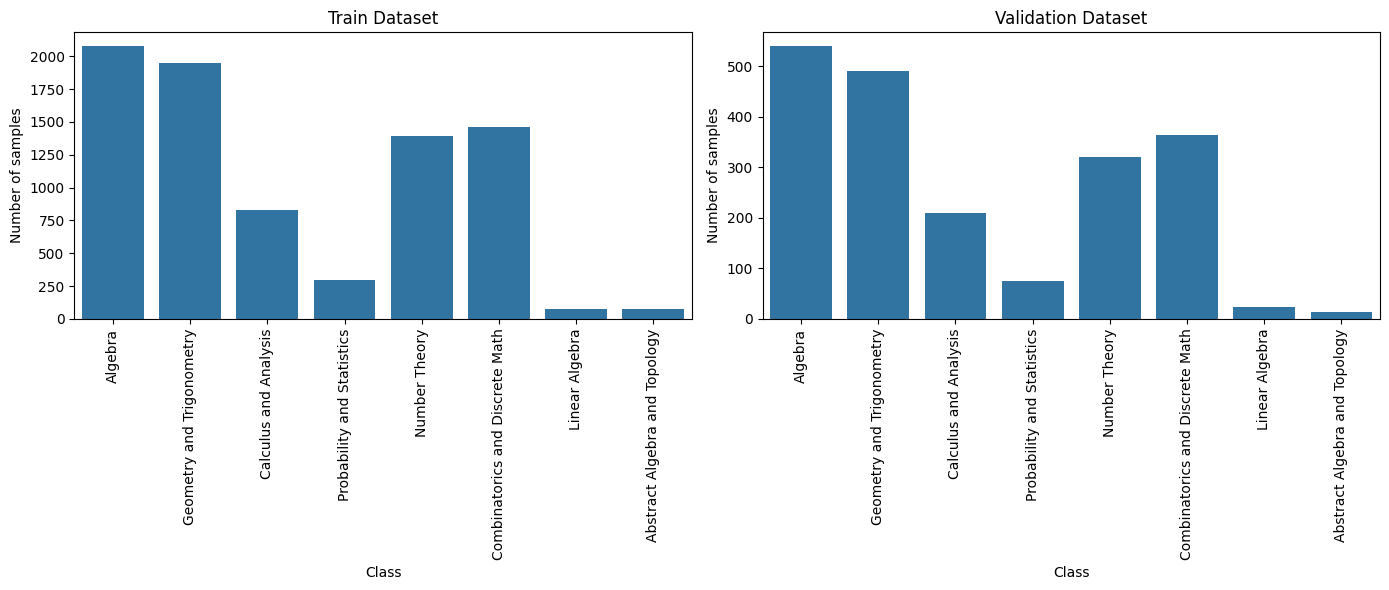

In [6]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(n_classes)
for idx, row in train_df.iterrows():
    label = row['label']
    train_class_counts[label] += 1

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(n_classes)
for idx, row in val_df.iterrows():
    label = row['label']
    val_class_counts[label] += 1

# посчитаем веса для каждого класса
class_weights = (sum(train_class_counts.tolist()) / (n_classes * train_class_counts)).tolist()
print(f"Class weights: {class_weights}")
class_weights = torch.tensor(class_weights)

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=classes_list, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of samples')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=classes_list, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of samples')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Импортируем модель

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer) #? нужен для чего

model.to(device)

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Формируем datasets и dataloaders

Для обучения с помощью Trainer API нам ну нужно вручную создавать dataset, dataloader и т д. Все за нас может сделать hugging face API, нам надо только
создать подходящие по формату датасеты. Но оставим пока этот код здесь, в будущем попробуем написать ручной пайплайн обучения.

In [8]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }

In [9]:
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
val_texts = val_df["text"].tolist()
val_labels = val_df["label"].tolist()

In [10]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

In [11]:
# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)

In [12]:
# # Токенизация данных
# def tokenize_function(examples):
#     return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

In [13]:
# tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
# tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# Baseline модель

In [14]:
def evaleate_model(model, dataloader, device):
    model.to(device)
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            batch.to(device)
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            preds.extend(predictions.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    cm = confusion_matrix(true_labels, preds)
    report = classification_report(true_labels, preds)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    # micro_f1 = f1_score(true_lables, preds, average='mocro')
    return (
        cm, 
        report, 
        accuracy, 
        # micro_f1,
    )

In [15]:
def plot_confusion_matrix(cm, classes, model_name=None, save_file_path=None):
    """
    Plots a confusion matrix for visualizing classification performance.

    This function takes the confusion matrix and class labels to create a heatmap
    visualization. It also allows saving the plot to a file or returning it
    without saving.

    Args:
        cm (numpy.ndarray): The confusion matrix array.
        classes (list): List of class names used in the model.
        model_name (string, optional): Name of the model for naming purposes. If None,
                                        does not set a title. Defaults to None.
        save_file_path (str, optional): Path where the plot should be saved. If None,
                                         the plot is displayed but not saved. Defaults to None.

    Returns:
        str: The filename or None if no saving occurs.

    Raises:
        AssertionError: If model_name is provided but save_file_path is not set.
    """
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        if model_name:
            assert save_file_path is not None
            plt.title(f"Confusion Matrix for {model_name}")
        else:
            plt.title("Confusion Matrix")
        
        if save_file_path is None:
            plt.show()
        else:
            # Verify that model_name exists before saving
            assert model_name, "model_name must be provided when save_file_path is not None"
            plt.savefig(f"{save_file_path}/confusion_matrix_{model_name}.jpg")
            return f"{save_file_path}/confusion_matrix_{model_name}.jpg"

Metrics for current model:
Test accuracy: 0.0275
              precision    recall  f1-score   support

           0       0.86      0.06      0.11       540
           1       0.00      0.00      0.00       491
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00        74
           4       0.50      0.01      0.02       321
           5       0.00      0.00      0.00       364
           6       0.01      0.92      0.02        24
           7       0.00      0.00      0.00        14

    accuracy                           0.03      2038
   macro avg       0.17      0.12      0.02      2038
weighted avg       0.31      0.03      0.03      2038



/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

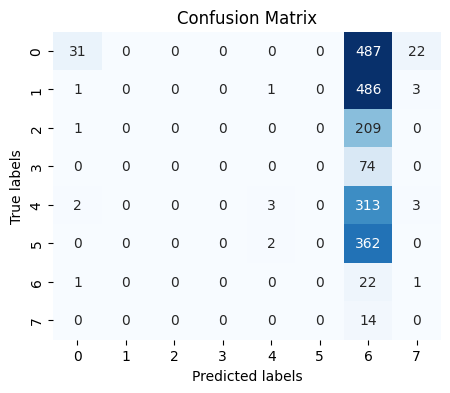

In [16]:
# cm, _, accuracy, micro_f1 = evaleate_model(model, tokenized_val_dataset, device)
cm, validation_report, accuracy = evaleate_model(model, val_loader, device)
print("Metrics for current model:")
print(f'Test accuracy: {accuracy:.4f}')
print(validation_report)
# print(f'Test F1 micro: {micro_f1:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))

# Тренировка модели

In [17]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_scheduler
import torch.nn as nn

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [27]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # loss в рамках 1 прохода по датасету (одной эпохи)
    correct = 0
    total = 0
    
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        # loss = outputs.loss
        
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=-1)
        labels = batch['labels']
        
        loss = criterion(logits, 
                         labels.type(torch.LongTensor).to(device))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #! добавить клипинк для предотвращения взрыва градиентов

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        running_loss += loss.item()
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader) # средняя ошибка за один проход по данным (за 1 эпоху)
    train_accuracy = correct / total
    # сохраняем данные по эпохе
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            # loss = outputs.loss
            logits = outputs.logits
            predicted = torch.argmax(logits, dim=-1)
            labels = batch['labels']
            
            loss = criterion(logits, 
                         labels.type(torch.LongTensor).to(device))
            
            val_loss += loss.item()
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


 33%|███▎      | 1019/3057 [02:32<05:05,  6.67it/s]


Epoch [1/3], Train Loss: 0.5762, Train Accuracy: 0.8470, Val Loss: 0.7434, Val Accuracy: 0.8189



 67%|██████▋   | 2040/3057 [03:39<22:00,  1.30s/it]

Epoch [2/3], Train Loss: 0.3287, Train Accuracy: 0.9192, Val Loss: 0.8261, Val Accuracy: 0.8440


Epoch [3/3], Train Loss: 0.1890, Train Accuracy: 0.9520, Val Loss: 0.8261, Val Accuracy: 0.8440


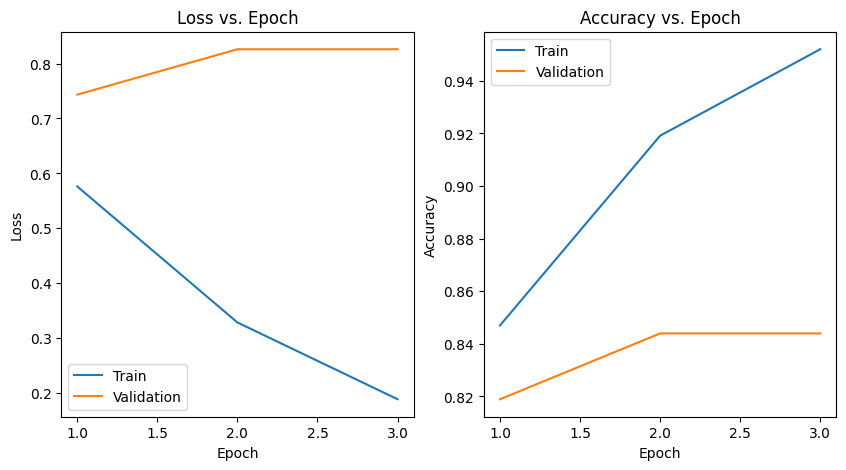

In [28]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

Metrics for current model:
Test accuracy: 0.8440
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       540
           1       0.92      0.94      0.93       491
           2       0.74      0.78      0.76       210
           3       0.86      0.91      0.88        74
           4       0.83      0.80      0.81       321
           5       0.81      0.84      0.82       364
           6       0.75      0.50      0.60        24
           7       0.71      0.71      0.71        14

    accuracy                           0.84      2038
   macro avg       0.81      0.79      0.79      2038
weighted avg       0.84      0.84      0.84      2038



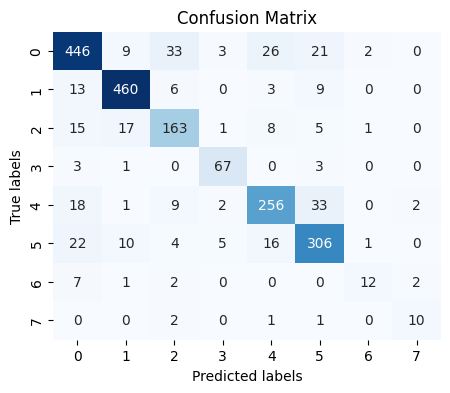

: 

In [ ]:
# cm, _, accuracy, micro_f1 = evaleate_model(model, tokenized_val_dataset, device)
cm, validation_report, accuracy = evaleate_model(model, val_loader, device)
print("Metrics for current model:")
print(f'Test accuracy: {accuracy:.4f}')
print(validation_report)
# print(f'Test F1 micro: {micro_f1:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))